## $\color{red}{\text{Presentation 3:}}$

### $\color{green}{\text{Part 1: Data Cleaning}}$

**Import Required Packages, Data, and Mount Drive:**

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd '/content/drive/MyDrive/Python Data'
churn_df = pd.read_excel('churn.xlsx', sheet_name = "BankChurners")

/content/drive/MyDrive/Python Data


## Data Transformation

**Seperating Numeric and Categorical Data:**

In [5]:
# Numeric component of HR dataset
churn_df_num = churn_df.select_dtypes(include = np.number) # Selecting only the numeric data of the dataset // select data types and including only numbers
churn_df_num.head()

# Categorical component of HR dataset
churn_df_cat = churn_df.select_dtypes(exclude = np.number) # Selecting only the categorical data // select data types and exluding numeric
churn_df_cat.head()

,Client_Attrition,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
0,NO,M,NaN,Married,$120K+,Gold
1,NO,M,Uneducated,NaN,$120K+,Blue
2,NO,M,NaN,Married,$120K+,Blue
3,YES,M,Graduate,Married,$120K+,Blue
4,NO,M,Post-Graduate,Single,$120K+,Blue


**Missing Value Analysis:**

In [6]:
# Function to compute missing values
def percent_missing(data):
    return data.isnull().sum().divide(len(data)).sort_values(ascending=False)

# Using the function
percent_missing(churn_df).head()

Total_Revolving_Bal    0.243902
Education_Level        0.149995
Income_Category        0.109805
Marital_Status         0.073961
Credit_Limit           0.003456
dtype: float64

**Imputation: Because there are variables with more than 15% of their data missing, we are choosing to remove them**

In [7]:
# Function to do conditional deletion

def semi_listwise(data, nan_percent):
    d1 = data.isnull().sum().divide(len(data)).sort_values(ascending=False)
    culprit_vars = []
    for i in range(len(d1.values)):
        if(d1.values[i] >= nan_percent):
            culprit_vars.append(d1.index[i])
    return data[data.columns.difference(culprit_vars)]

In [8]:
delCol15_num = semi_listwise(churn_df_num, 0.15) # Deleting all columns with 15% missing data

# Check if deletion worked
print(churn_df_num.shape) # Printing shape of original data
print(delCol15_num.shape) # Printing shape of deleted columns

(10127, 15)
(10127, 14)


In [9]:
# Find the median
col_med = delCol15_num.median() # calculating the median for each column
# print(col_med) # Printing the medians for each column

# Now inpute missing data with the median
churn_df_full = delCol15_num.fillna(col_med) # Filling in missing data with the median for each column

# Now check if data is missing
percent_missing(churn_df_full)

Age                      0.0
Avg_Open_To_Buy          0.0
Avg_Utilization_Ratio    0.0
Client_ID                0.0
Contacts_In12Mon         0.0
Credit_Limit             0.0
Dependent_Count          0.0
Inactive_In12Mon         0.0
Months_With_Bank         0.0
Products_By_Clients      0.0
Total_Amt_Chng_Q4_Q1     0.0
Total_Ct_Chng_Q4_Q1      0.0
Total_Trans_Amt          0.0
Total_Trans_Ct           0.0
dtype: float64

**Addressing Multicolinearity:**

In [11]:
#!pip install dython
from dython.nominal import associations
import seaborn as sns

def corrPlot(data):

  # Use "associations" function to compute correlation between all variables
  corr_matrix = associations(dataset=data, compute_only=True)['corr']

  # Mask the upper triangle of correlation heatmap
  mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))

  # Plotting correlation heatmap
  plt.figure(figsize=(12, 8))
  sns.heatmap(corr_matrix, annot=True, mask=mask_upper, cmap='coolwarm_r', fmt='.2f', vmin=-1, vmax=1)
  plt.show()

In [12]:
'''
This function drops highly correlated variables given a threshold.
It drops the variable with smaller variance
'''

def drop_highly_correlated(data, threshold):
    cor_matrix = data.corr().abs()
    sol = (cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))).unstack().dropna()

    to_drop=[]
    for i in range(len(sol[sol > threshold].index.tolist())):
        var1 = sol[sol >= threshold].index.tolist()[i][0]
        var2 = sol[sol >= threshold].index.tolist()[i][1]

        if(data[var1].var() < data[var2].var()): to_drop.append(var1)
        else: to_drop.append(var2)

    dropped_vars = list(set(to_drop))
    return dropped_vars, data.drop(dropped_vars, axis=1)

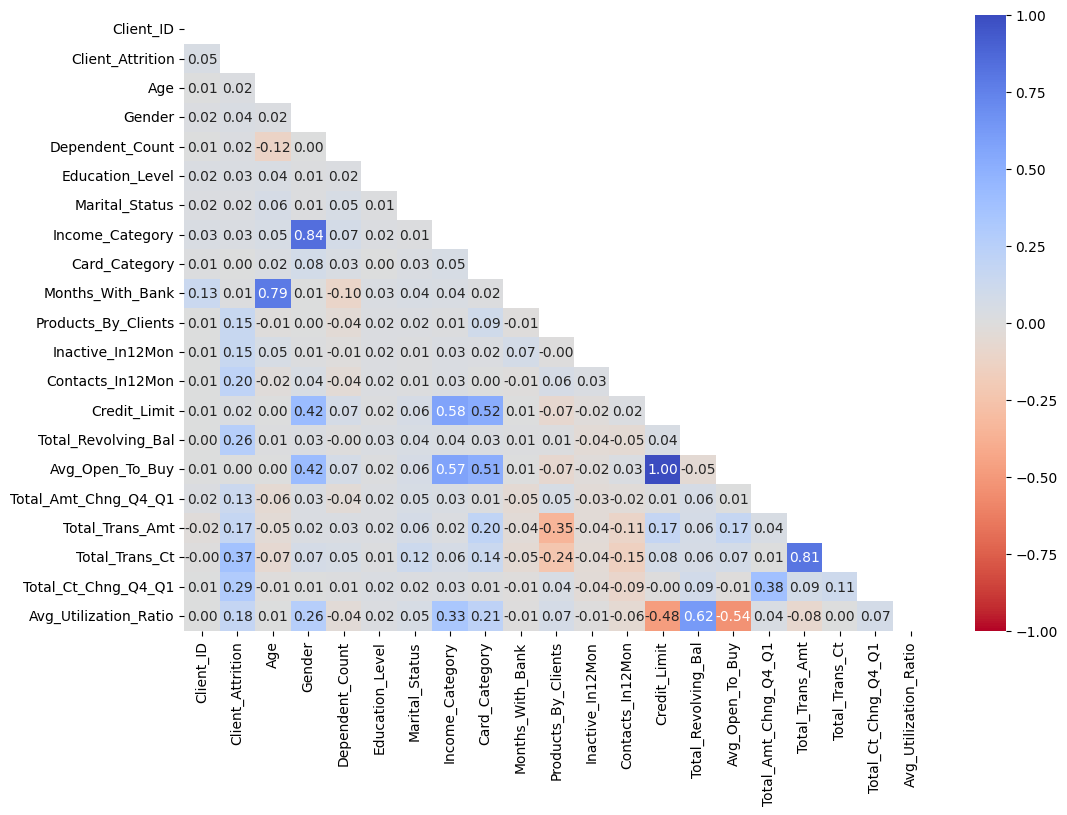

In [21]:
# use the t function to remove variables with high correlation
dropped_vars, churn_new_v2 = drop_highly_correlated(data = churn_df_full, threshold = 0.7)

# Plot the correlation of the resulting data
corrPlot(data = churn_df)

In [14]:
delCol15_num.head()

,Age,Avg_Open_To_Buy,Avg_Utilization_Ratio,Client_ID,Contacts_In12Mon,Credit_Limit,Dependent_Count,Inactive_In12Mon,Months_With_Bank,Products_By_Clients,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct
0,51,32252.0,0.066,810347208,3,34516.0,4,1,46,6,1.975,0.722,1330,31
1,42,5281.0,0.217,708790833,2,6748.0,5,3,31,5,0.831,0.680,1201,42
2,49,17246.0,0.127,712813458,0,19763.0,2,2,36,4,0.664,0.250,1414,35
3,56,15769.0,0.000,714374133,3,15769.0,2,3,36,1,1.041,0.364,602,15
4,44,21855.0,0.088,710082708,2,23957.0,4,4,32,2,0.997,0.733,1276,26


Removing Near Zero Variance Variables:

In [22]:
from sklearn.feature_selection import VarianceThreshold

vThreshold = VarianceThreshold(threshold = 0.1)
vThreshold.fit_transform(churn_new_v2)

# Get variables with greater variance
vars = churn_new_v2.columns[vThreshold.get_support()]

# Subset data for variables with greater variance
churn_varDf = churn_new_v2[vars]

# Dropping 'Client_ID' as it is not needed for analysis
new_churn_var_df = churn_varDf.drop(columns = ['Client_ID'])

Standardization:

In [23]:
from sklearn.preprocessing import StandardScaler

# Standardize data // comparing variables 'apples to apples'
churn_std = StandardScaler().fit_transform(new_churn_var_df)
# Transforms churn_std into a data frame and getting column names instead of numbers
churn_stdDf = pd.DataFrame(churn_std, columns = new_churn_var_df.columns)

# Bring the dependent variable to the standardized data // do NOT standardize dependent variable
churn_std_full = pd.concat([churn_stdDf, churn_df['Avg_Utilization_Ratio']], axis = 1)

Data Partitoning:

In [24]:
from sklearn.model_selection import train_test_split

# Independent variables used for regression
depVar = churn_std_full['Avg_Utilization_Ratio']

# Exclude 'Avg_Utilization_Ratio' column
indVar = churn_std_full.drop(columns=['Avg_Utilization_Ratio'])

# Partition data into training(70%) and testing(30%).
trainX, testX, trainY, testY = train_test_split(indVar, depVar, test_size = 0.3, random_state = 1)

### $\color{green}{\text{Part 2: Modeling}}$

## $\color{blue}{\text{Linear Regression}}$

### $\color{white}{\text{Multiple Linear Regression Model Training and Output}}$

In [25]:
import statsmodels.api as sm

#add the intercept term to the data
trainX = sm.add_constant(trainX)

#Model with training data
mlr_model = sm.OLS(trainY, trainX).fit()

#print the model summary
print(mlr_model.summary())

                              OLS Regression Results                             
Dep. Variable:     Avg_Utilization_Ratio   R-squared:                       0.293
Model:                               OLS   Adj. R-squared:                  0.292
Method:                    Least Squares   F-statistic:                     419.4
Date:                   Sat, 20 Apr 2024   Prob (F-statistic):               0.00
Time:                           02:29:00   Log-Likelihood:                 289.39
No. Observations:                   7088   AIC:                            -562.8
Df Residuals:                       7080   BIC:                            -507.8
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cons

In [26]:
trainX.isnull().sum()

const                  0
Age                    0
Avg_Open_To_Buy        0
Contacts_In12Mon       0
Dependent_Count        0
Inactive_In12Mon       0
Products_By_Clients    0
Total_Trans_Amt        0
dtype: int64